# Using DESC Interactively

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('.'))
sys.path.append(os.path.abspath('../../'))

In [2]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from desc.equilibrium import Equilibrium
from desc.plotting import plot_1d, plot_2d, plot_3d, plot_section, plot_surfaces

DESC version v0.4.4, using JAX backend, jax version=0.2.10, jaxlib version=0.1.62, dtype=float64
Using device: CPU, with 20.65 GB available memory


## Initializing an Equilibrium

Let's start with a simple example of a circular tokamak. We'll start by defining the boundary, which is a numpy array with columns for `l`, `m`, `n`, `R`, `Z` which give the mode numbers and spectral coefficients that describe the boundary. DESC allows boundary conditions to be imposed either on the last closed flux surface (for which `l` should be set to zero, giving a double fourier series in $\theta$, $\phi$), or on the $\phi=0$ Poincare section (for which `n` should be set to zero, giving a zernike series in $\rho$, $\theta$)

Giving the boundary conditions on the last closed flux surface is the traditional method so we'll go with that:

**Note**: in DESC, radial modes are indexed by `l`, poloidal modes by `m`, and toroidal modes by `n`

In [3]:
                # l,m,n,R,Z
bdry = np.array([[0,0,0,10,0],
                 [0,1,0,1,0],
                 [0,-1,0,0,1]])

Next, we need to define the profiles. We'll take a vacuum case to start (pressure=0), and a simple quadratic $\iota$ profile. The profiles are given in terms a simple monic power series in powers of $\rho^l$:

In [4]:
                   #  l  p   i
profiles = np.array([[0, 0., 1],
                     [1, 0.,  0],
                     [2, 0., 1.5]])

Finally, we need to specify what resolution we want to use, in terms of maximum mode numbers `L`,`M`,`N` for the radial, poloidal, and toroidal directions respectively, as well as the total flux

In [5]:
L = 6
M = 6
N = 0 #its a tokamak so we don't need any toroidal modes
NFP = 1 # number of field periods
Psi = 1 # flux (in Webers) within the last closed flux surface

# optional parameters:
M_grid=8 # if we want to oversample the collocation nodes
N_grid=0
sym=True # explicity enforce stellarator symmetry 

we put the inputs into a dictionary and then use that to create an Equilibrium object

In [6]:
inputs = {"boundary":bdry,
          "bdry_mode": "lcfs",
          "profiles":profiles,
          "L":L,
          "M":M,
          "N":N,
          "NFP":NFP,
          "Psi":Psi,
          "M_grid":M_grid,
          "N_grid":N_grid,
          "sym": sym}

eq = Equilibrium(inputs)

This automatically creates the spectral bases and generates an initial guess for the flux surfaces by scaling the boundary surface, which we can plot below:

## Plotting

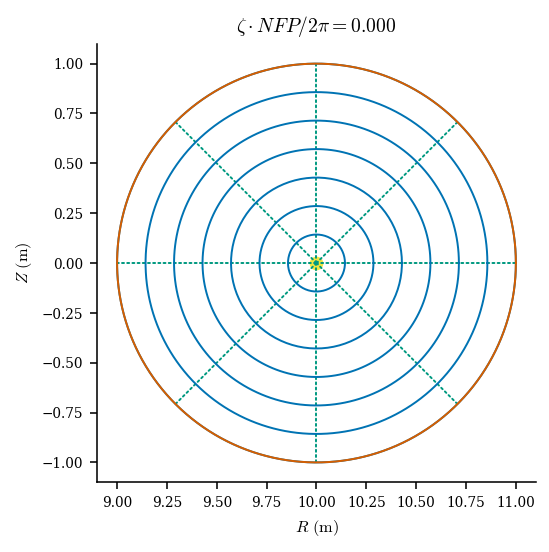

In [7]:
# plot_surfaces generates poincare plots of the flux surfaces
plot_surfaces(eq);

We can also look at the force balance error:

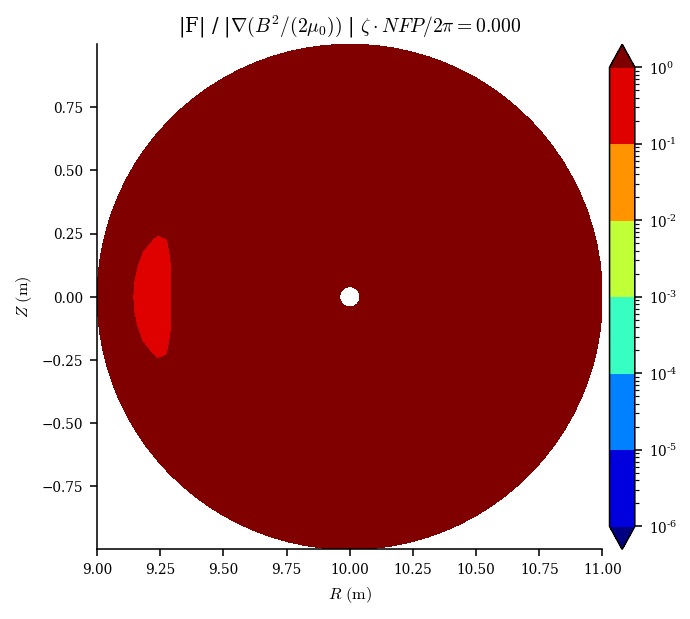

In [8]:
# plot_section plots various quantities on a toroidal cross section
# the second argument is a string telling it what to plot, in this case the force error density
# we could also look at B_z, (the toroidal magnetic field), or g (the coordinate jacobian) etc,
# here we also tell it to normalize the force error (relative to the magnetic pressure gradient or thermal pressure if present)
plot_section(eq,"|F|", norm_F=True, log=True);

We see that this is very far from an equilibrium. Let's try to fix that.

## Solving the Equilibrium

First, we need to give the equilibrium an objective that should be minimized, in this case we'll choose to minimize the force balance error. 

We also need to select an optimizer. Many options from `scipy.optimize` are available, as well as a few custom solvers that may be more efficient in some cases

In [9]:
eq.objective = "force"
eq.optimizer = "scipy-trf"

Next, we simply call `eq.solve()` to minimize the force balance error. Here we can also pass in arguments to the optimizer such as maximum number of iterations or stopping tolerances (we only run a few iterations here to show the idea). 

Under the hood, the objective function and its derivative are JIT compiled for the specific parameters we defined above before being passed to the optimizer.

In [10]:
eq.solve(verbose=2, ftol=1e-4);

Compiling objective function and derivatives
Timer: Objective compilation time = 2.11 sec
Timer: Jacobian compilation time = 6.06 sec
Timer: Total compilation time = 8.18 sec
Starting optimization
`ftol` termination condition is satisfied.
Function evaluations 210, initial cost 2.5447e+10, final cost 1.4996e-01, first-order optimality 3.27e+05.
Timer: Solution time = 1.08 sec
Timer: Avg time per step = 5.15 ms
Start of solver
Total residual:  2.545e+10  f_rho:  1.903e+05  f_beta:  1.211e+05
End of solver
Total residual:  1.500e-01  f_rho:  2.707e-01  f_beta:  4.761e-01


We can then look at the flux surfaces and force error again:

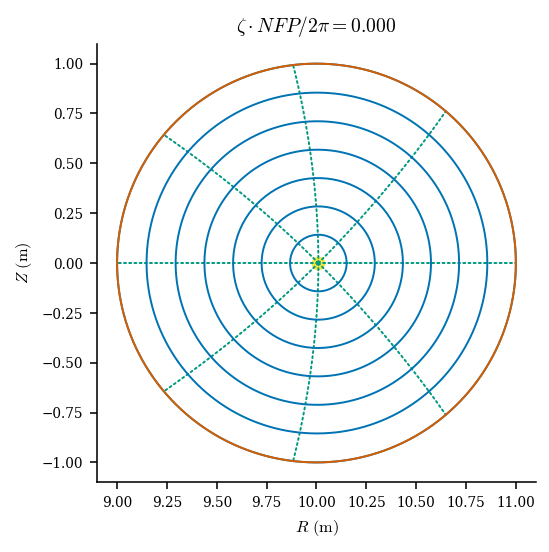

In [11]:
plot_surfaces(eq);

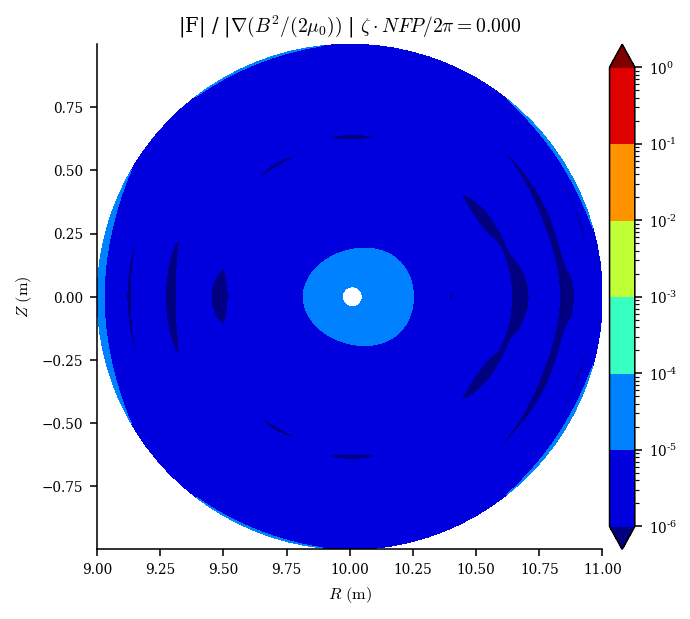

In [12]:
plot_section(eq,"|F|", norm_F=True, log=True);

## Perturbations

Next, we can ask "what would this equilibrium look like if we add pressure to it?"

We can answer this by applying a pressure perturbation to the current equilibrium. 

First, let's plot the pressure to make sure it's really zero:

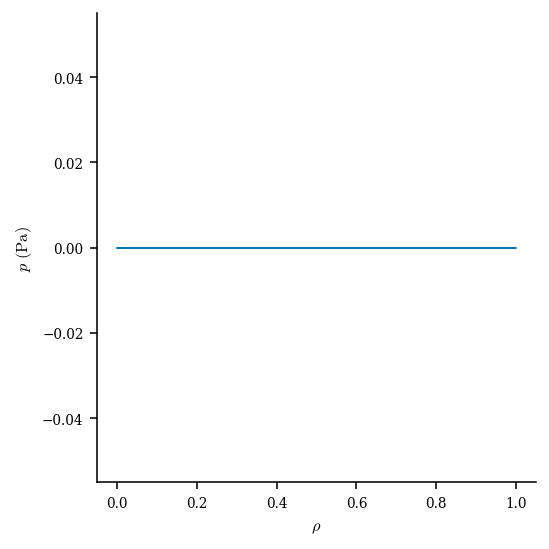

In [13]:
plot_1d(eq,"p");

Next, let's decide on how much we want to increase the pressure.

We'll give it a quadratic profile, peaked at 5000 Pascals in the core and dropping to 0 at the edge.

The perturbation is given in the same form the original profiles were (a power series in $\rho$)

In [14]:
delta_p = np.zeros_like(eq.p_l)
delta_p[0] = 1000.
delta_p[2] = -1000.


In [15]:
eq1 = eq.perturb(dp=delta_p, order=2)

Perturbing p_l
Precomputing Transforms
Factorizing boundary constraint
Computing df
Factoring df
Computing d^2f


Note that this gives us back a new equilibrium, so that the original is saved for future study. The new equilibrium keeps track of where it came from though, and the old equilibrium knows about the new one:

In [16]:
print("old == new: ",eq1 == eq)
print("new is child of old:", eq1 in eq.children)
print("old is parent of new:", eq1.parent is eq)

old == new:  False
new is child of old: True
old is parent of new: True


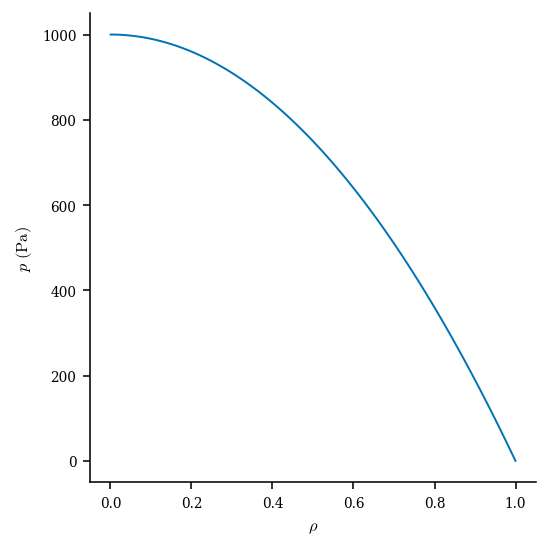

In [17]:
plot_1d(eq1,"p");

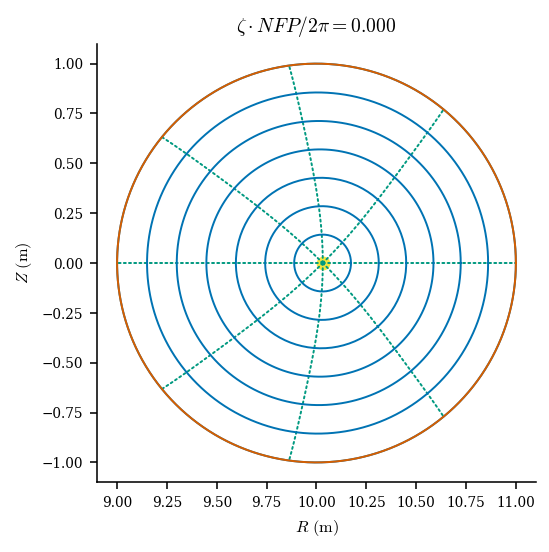

In [18]:
plot_surfaces(eq1);

Note the changes in the flux surface, and the slight outward movement of the axis:

In [19]:
print("eq axis: ",eq.compute_axis_location())
print("eq1 axis: ",eq1.compute_axis_location())

eq axis:  (array([10.00964746]), array([0.]))
eq1 axis:  (array([10.03165781]), array([0.]))


During the perturbation, the force error increased slightly, but still remains less than 10%

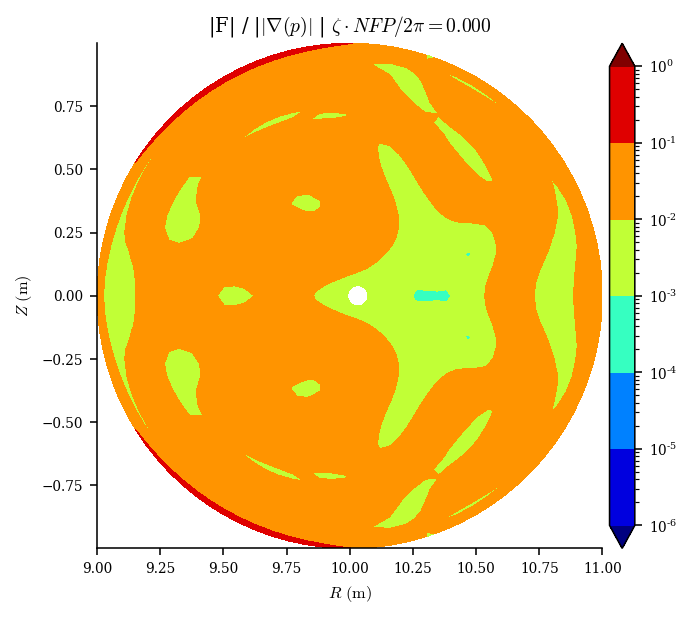

In [20]:
plot_section(eq1,"|F|", norm_F=True, log=True);

We can do a few Newton iterations to converge the solution again, this should go much faster than the initial solution

In [21]:
eq1.solve(verbose=2, ftol=1e-4);

Starting optimization
`ftol` termination condition is satisfied.
Function evaluations 20, initial cost 1.6179e+05, final cost 8.7801e+01, first-order optimality 3.80e+04.
Timer: Solution time = 142 ms
Timer: Avg time per step = 7.14 ms
Start of solver
Total residual:  1.618e+05  f_rho:  5.264e+02  f_beta:  2.155e+02
End of solver
Total residual:  8.780e+01  f_rho:  8.343e+00  f_beta:  1.030e+01


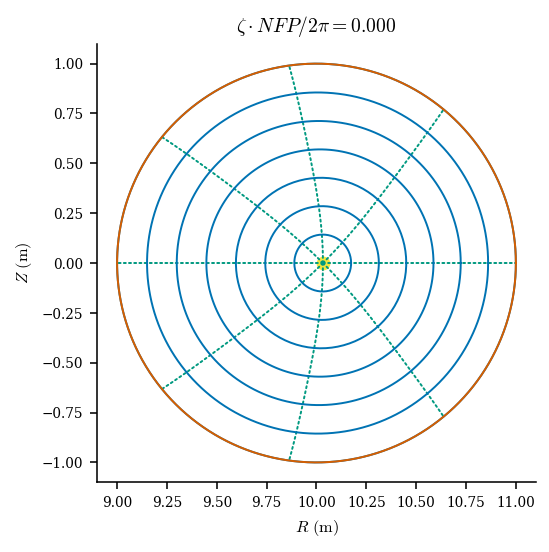

In [22]:
plot_surfaces(eq1);

Note that the flux surfaces and axis location only change by a tiny amout during the Newton iterations - the perturbation captured them accurately

In [23]:
print("eq axis: ",eq.compute_axis_location())
print("eq1 initial axis: ",eq1.initial.compute_axis_location())
print("eq1 axis: ",eq1.compute_axis_location())

eq axis:  (array([10.00964746]), array([0.]))
eq1 initial axis:  (array([10.03165781]), array([0.]))
eq1 axis:  (array([10.03245123]), array([0.]))


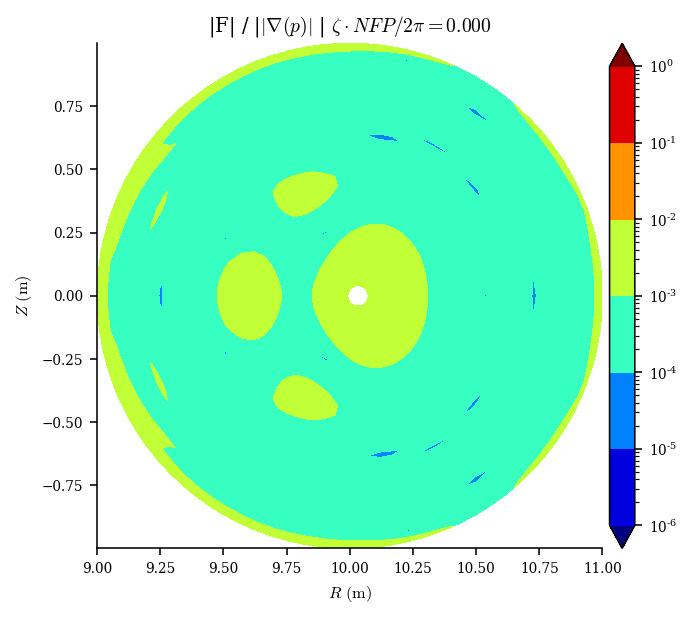

In [24]:
plot_section(eq1,"|F|", norm_F=True, log=True);

Next, we might want to try twisting our tokamak into a stellarator. We can accomplish this in a similar way, by applying a 3d boundary perturbation.

However, first we need to give our tokamak some non-axisymmetric modes in its spectral basis:

In [25]:
eq1.change_resolution(N=2,N_grid=3)

Now we can apply a 3d perturbation by perturbing the coefficients of the double Fourier series that defines the plasma boundary:

In [26]:
delta_R = np.zeros_like(eq1.Rb_lmn)
delta_Z = np.zeros_like(eq1.Zb_lmn)
delta_R[eq1.Rb_basis.get_idx(M=1,N=1)] = -0.4
delta_Z[eq1.Zb_basis.get_idx(M=1,N=-1)] = -0.4

eq2 = eq1.perturb(dRb=delta_R, dZb=delta_Z,order=2)

Perturbing Rb_lmn, Zb_lmn
Precomputing Transforms
Factorizing boundary constraint
Computing df
Factoring df
Computing d^2f


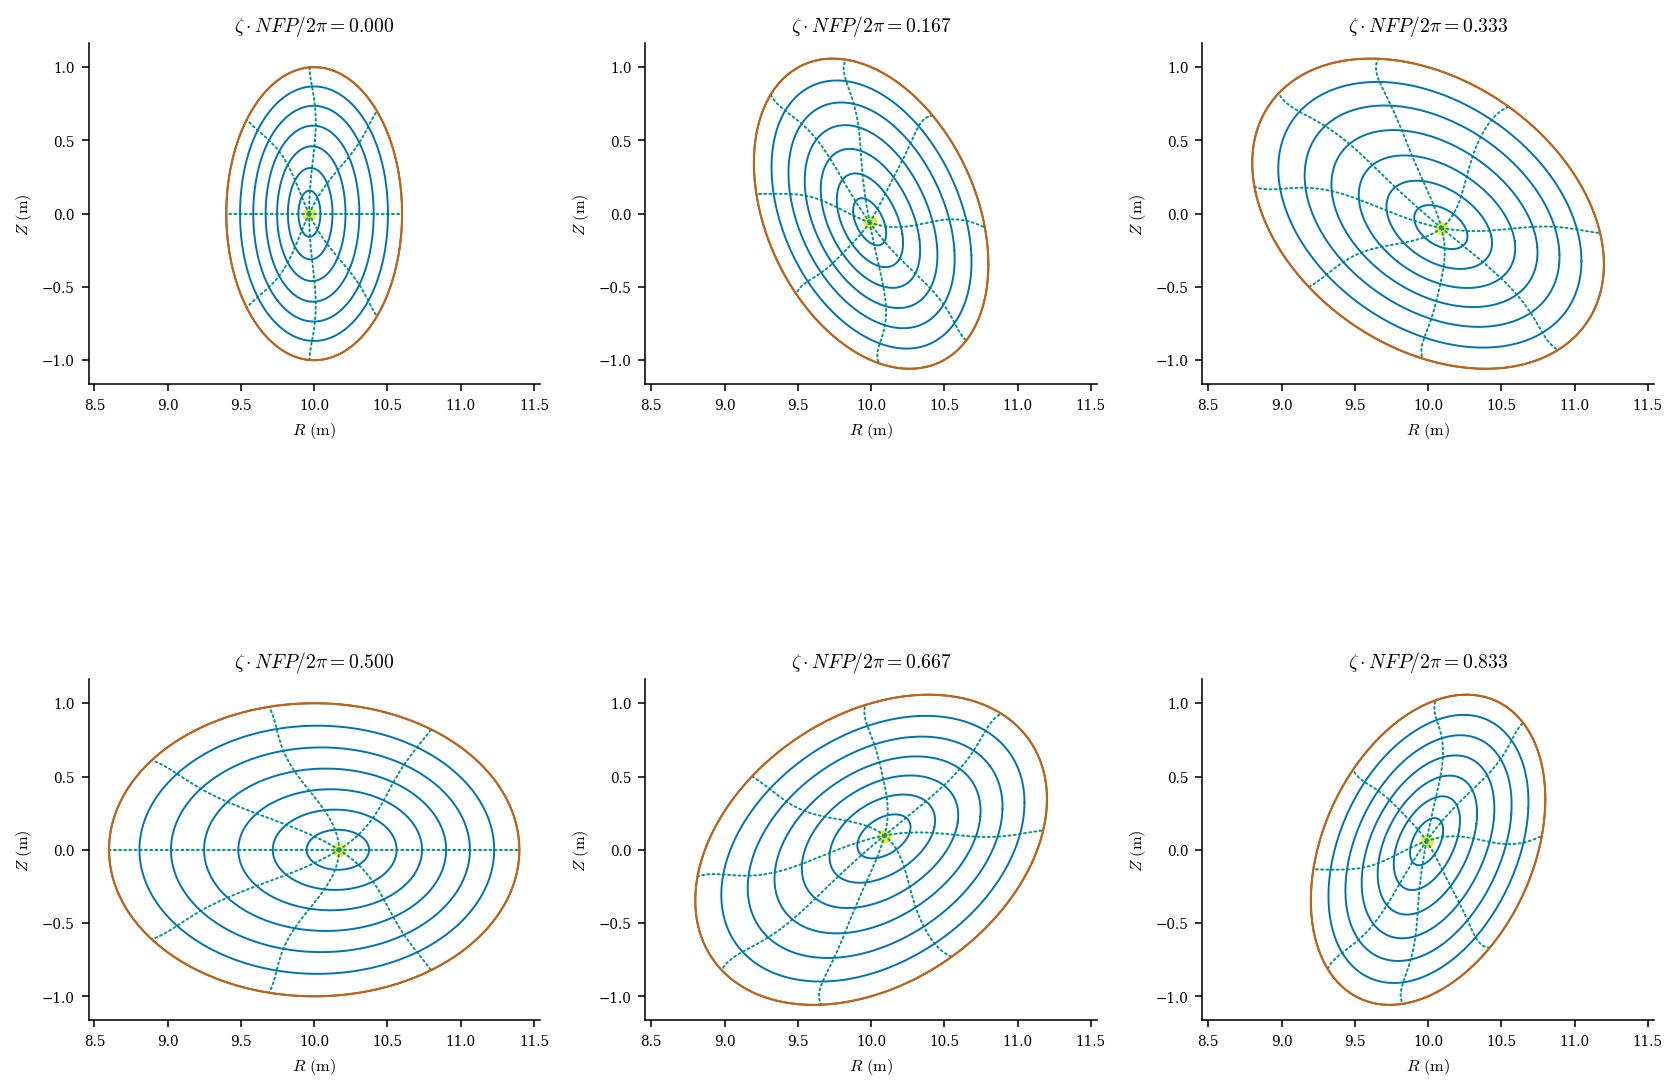

In [27]:
plot_surfaces(eq2);

Again, note that the force error increases after the perturbation. How much it increases depends on the "size" of the perturbation (note that due to the highly nonlinear equations, the "size" of the perturbation required to maintain force balance depends on the starting equilibrium as well as the actual delta).

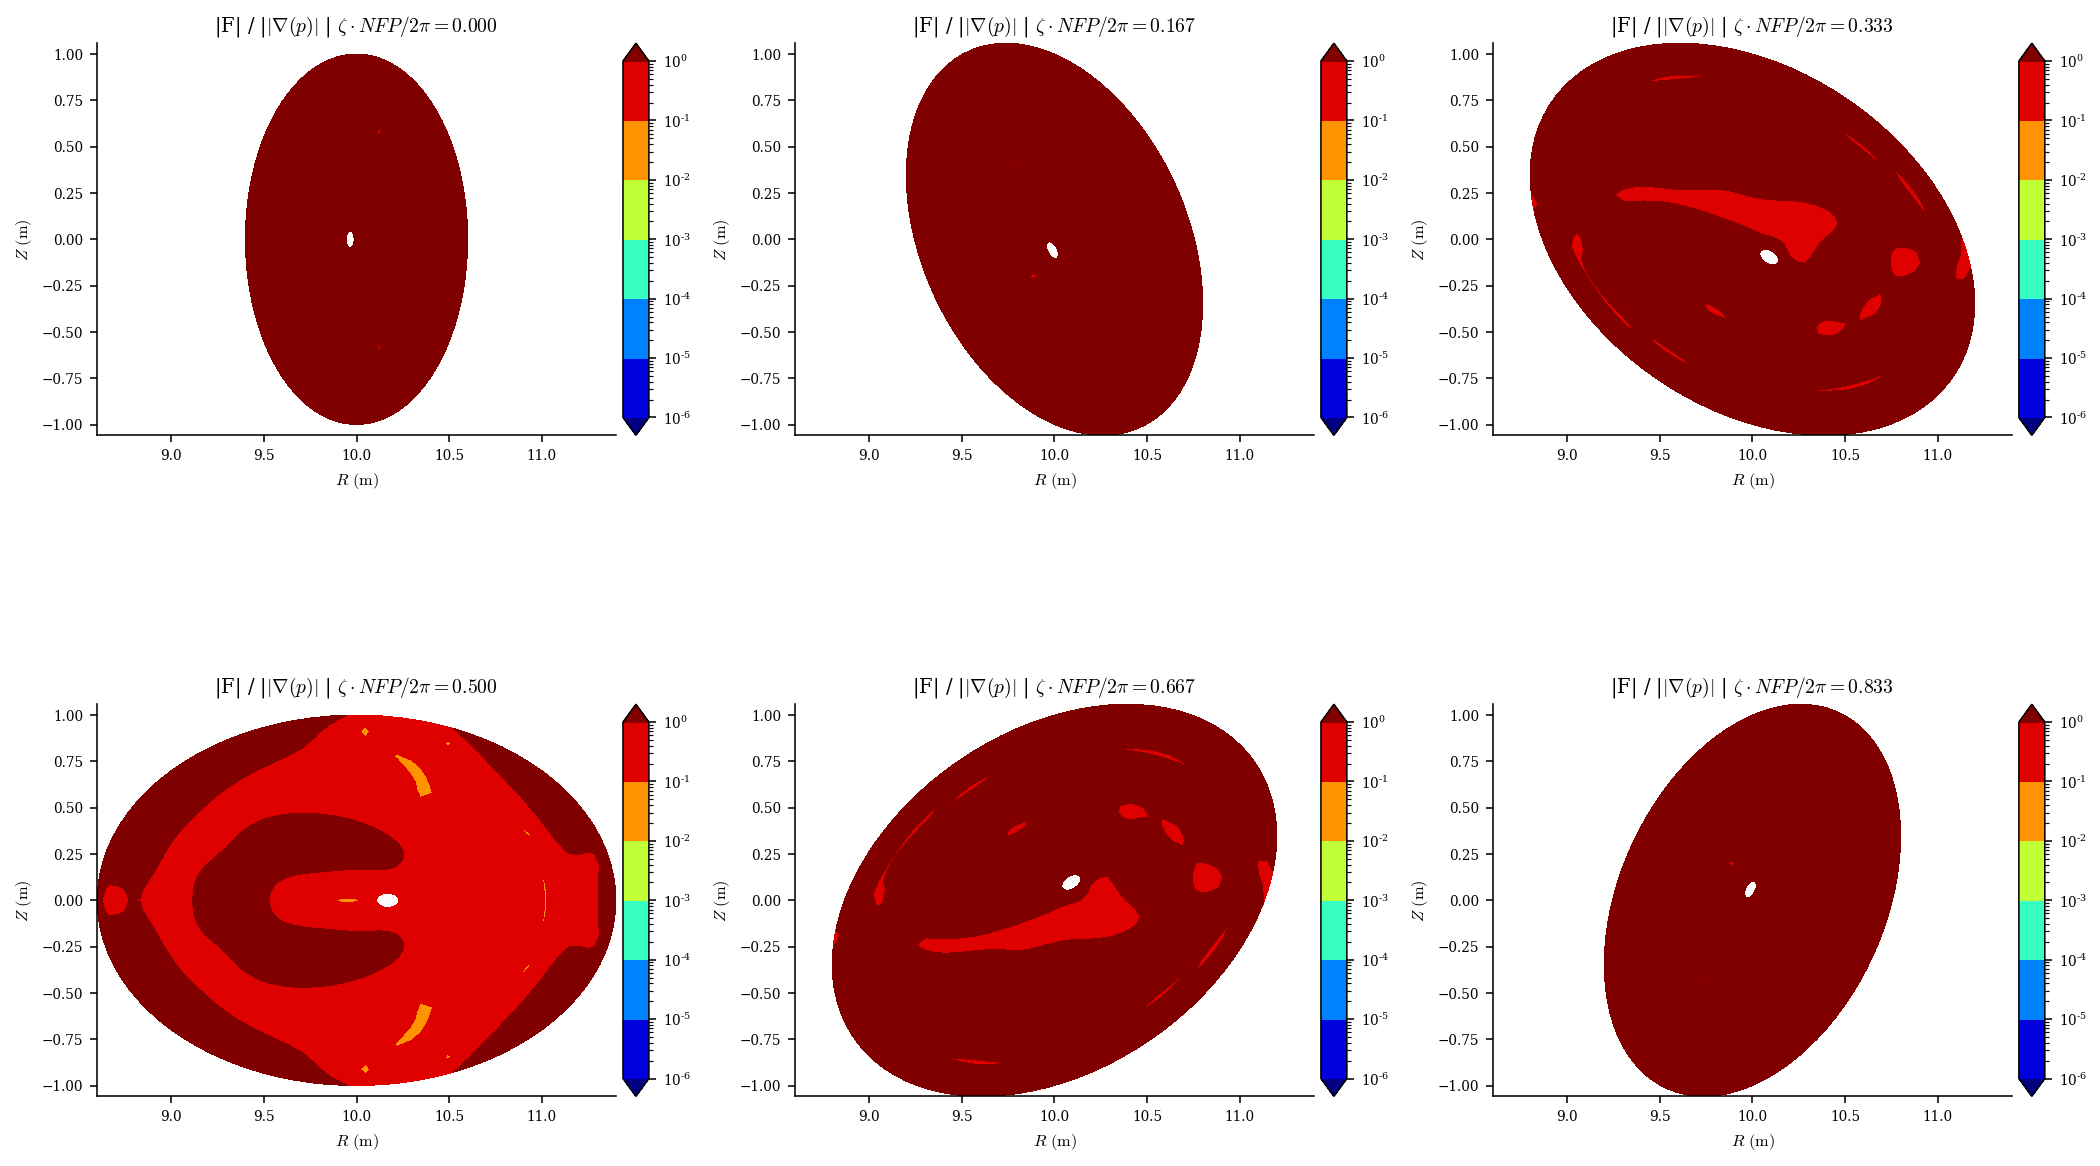

In [28]:
plot_section(eq2,"|F|", norm_F=True, log=True);

We can again run a few additional Newton iterations to improve the force balance error.

In [29]:
eq2.solve(verbose=2,ftol=1e-2);

Compiling objective function and derivatives
Timer: Objective compilation time = 729 us
Timer: Jacobian compilation time = 98.6 ms
Timer: Total compilation time = 100 ms
Starting optimization
`ftol` termination condition is satisfied.
Function evaluations 25, initial cost 9.2132e+09, final cost 9.0372e+03, first-order optimality 1.26e+08.
Timer: Solution time = 4.94 sec
Timer: Avg time per step = 197 ms
Start of solver
Total residual:  9.213e+09  f_rho:  1.317e+05  f_beta:  3.301e+04
End of solver
Total residual:  9.037e+03  f_rho:  5.981e+01  f_beta:  1.204e+02


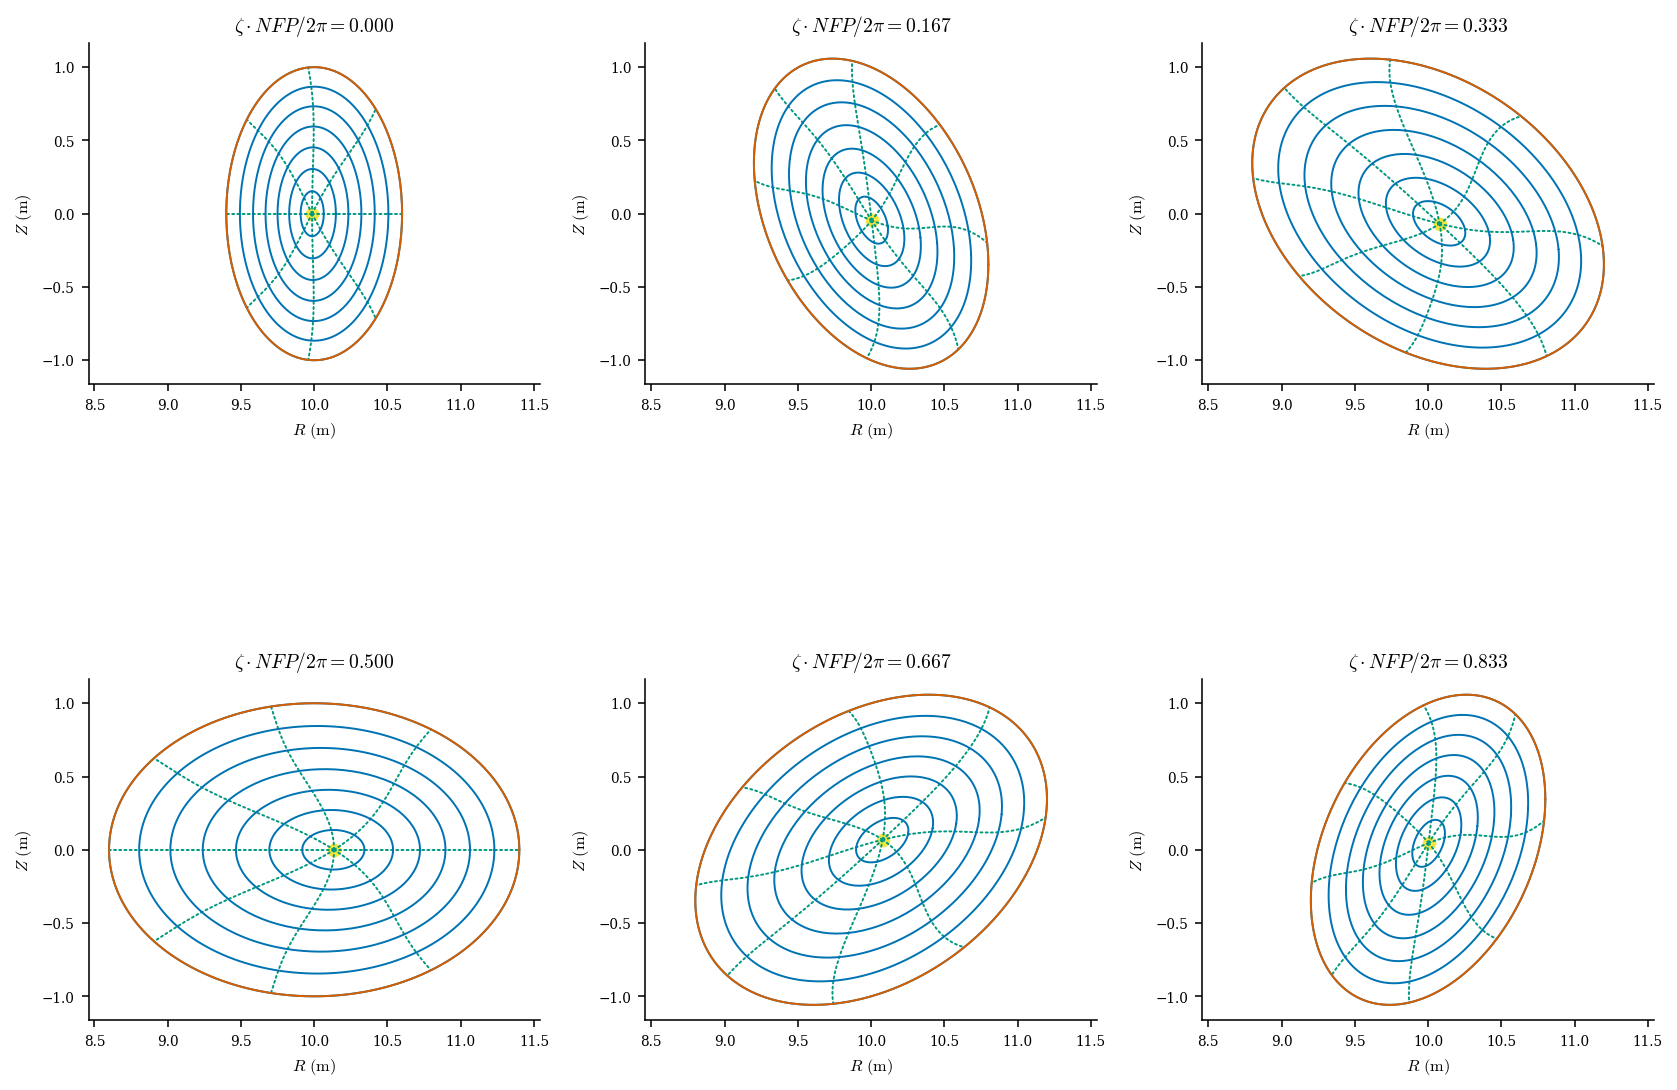

In [30]:
plot_surfaces(eq2);

Note again how the flux surfaces remain very similar, as the perturbation captures them accurately. Additional Newton iterations primarily serve to reduce the force error

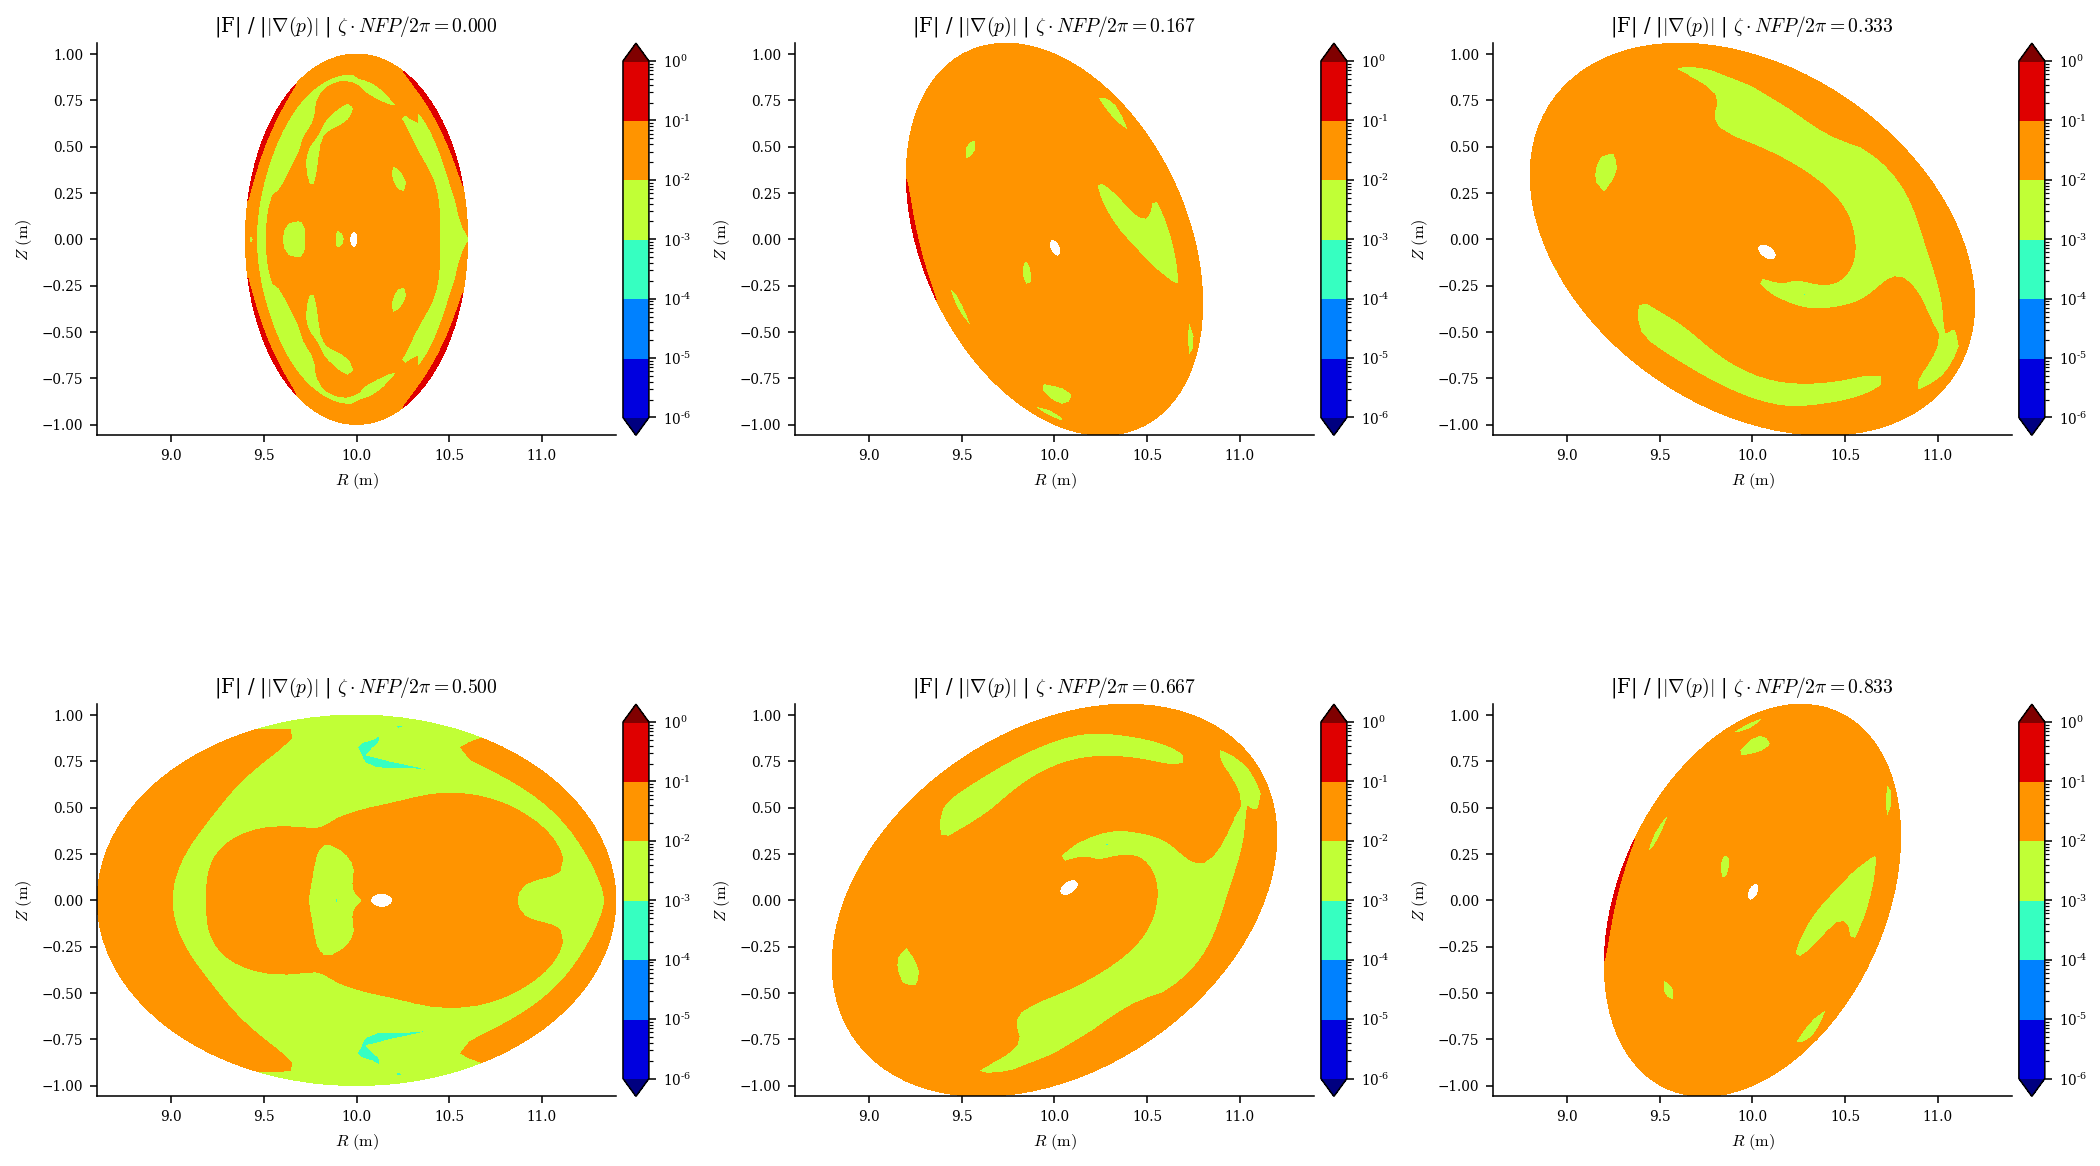

In [31]:
plot_section(eq2,"|F|", norm_F=True, log=True);

Note that even after additional Newton iterations, the force error is still rather high (between 1% and 10% throughout most of the volume). This is because the resolution we used was rather low, meant to be a quick demonstration rather than a realistic high quality solution. As DESC uses a pseudo-spectral discretization, increasing the resolution should decrease the error roughly exponentially.